In [1]:
import numpy as np
import ray

from q1physrl import analyse, train, phys, env
import matplotlib.pyplot as plt

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
ray.init()

2020-02-21 16:38:40,781	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-21 16:38:40,839	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-21 16:38:40,928	INFO resource_spec.py:212 -- Starting Ray with 1.46 GiB memory available for workers and up to 0.75 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-21 16:38:41,214	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-02-21 16:38:41,298	WARNING services.py:1004 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


{'node_ip_address': '192.168.178.24',
 'redis_address': '192.168.178.24:23429',
 'object_store_address': '/tmp/ray/session_2020-02-21_16-38-40_783265_23407/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-21_16-38-40_783265_23407/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-02-21_16-38-40_783265_23407'}

In [3]:
config = env.Config(
    num_envs=1,
    auto_jump=False,
    time_limit=5,
    key_press_delay=0.3,
    initial_yaw_range=(0, 360),
    max_initial_speed=700,
    zero_start_prob=1.0,
)

trainer = train.make_trainer(train.make_run_config(config))

2020-02-21 16:38:42,019	INFO trainer.py:377 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-21 16:38:42,092	ERROR logger.py:328 -- pip install 'ray[tune]' to see TensorBoard files.
2020-02-21 16:38:42,094	WARNING logger.py:417 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-02-21 16:38:42,102	INFO trainer.py:524 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=23460) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=23460)   warnings.warn(msg)
(pid=23457) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=23457)   warnings.warn(msg)
(pid=23458) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=23458)   warnings.warn(msg)
(pid=23459) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma modu

2020-02-21 16:38:57,383	INFO trainable.py:178 -- _setup took 15.282 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-02-21 16:38:57,384	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-21 16:38:57,386	WARNING util.py:44 -- Install psutil to monitor system performance.


In [4]:
# FNAME = '../checkpoints/checkpoint-7867'
# FNAME = '../checkpoints/checkpoint-5199'
# FNAME = '../checkpoints/checkpoint-7781'
# FNAME = '../checkpoints/checkpoint-8718'
# FNAME = '../checkpoints/checkpoint-8765'
# FNAME = '../checkpoints/checkpoint-11625'
# FNAME = '../checkpoints/checkpoint-2458'
# FNAME = '../checkpoints/checkpoint-279'
# FNAME = '../checkpoints/checkpoint-291'
# FNAME = '../checkpoints/checkpoint-98'
# FNAME = '../checkpoints/checkpoint-194'
FNAME = '../checkpoints/checkpoint-1785'

trainer.restore(FNAME)

2020-02-21 16:38:58,307	WARNING trainable.py:210 -- Getting current IP.
2020-02-21 16:38:58,308	INFO trainable.py:416 -- Restored on 192.168.178.24 from checkpoint: ../checkpoints/checkpoint-1785
2020-02-21 16:38:58,310	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 1785, '_timesteps_total': 89250000, '_time_total': 60705.65846967697, '_episodes_total': 413179}


In [5]:
r = analyse.eval_sim(trainer, config)

/home/matt/100m-rl/q1physrl/phys.py:89: RuntimeWarning: invalid value encountered in true_divide
  return np.where((speed > 0)[:, None], h_vel * (new_speed / speed)[:, None], h_vel)
/home/matt/100m-rl/q1physrl/phys.py:99: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:104: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),


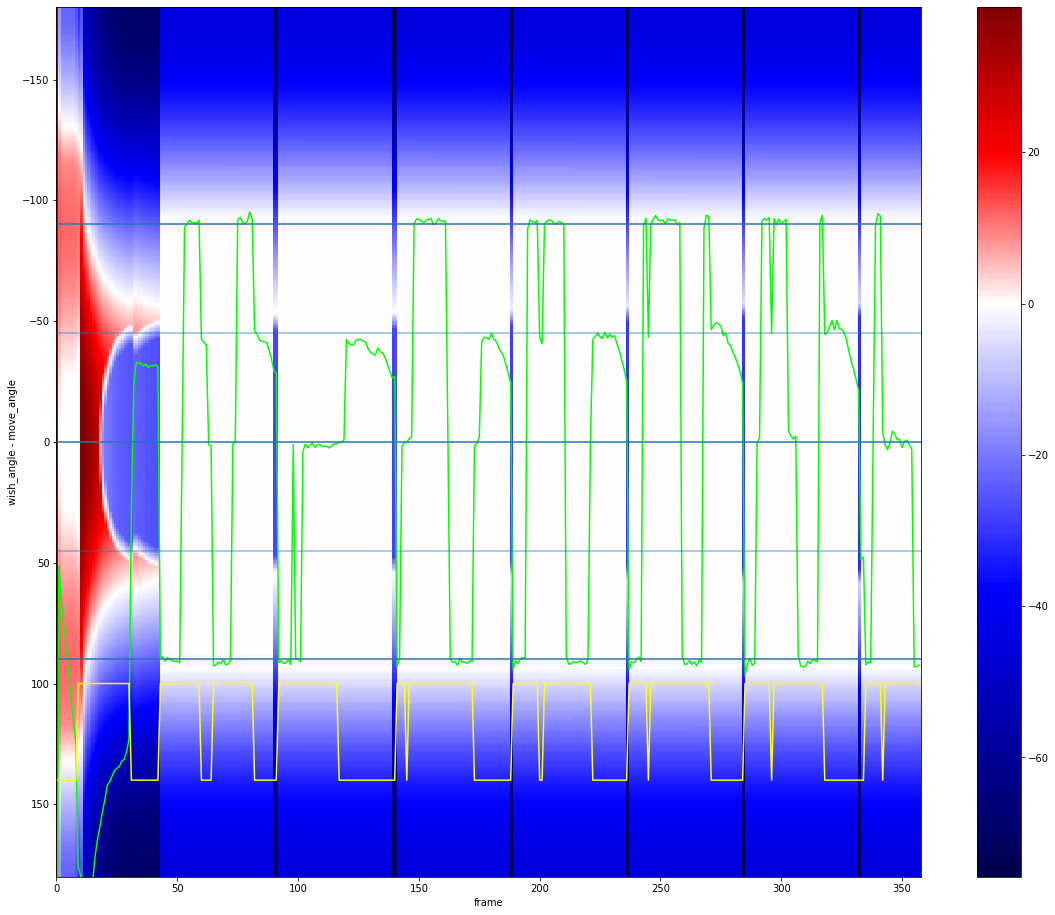

In [6]:
r.wish_angle_yaw_plot()

Plot relative angle with a backing image showing the delta v that would be attained if the relative angle were there

In [7]:
# delta_speeds = []

# move_angle = 180. * np.arctan2(r.player_state.vel[:, 1], r.player_state.vel[:, 0]) / np.pi

# for rel_wish_angle in np.arange(-180, 180):
#     inputs = phys.Inputs(
#         yaw=move_angle + rel_wish_angle,
#         pitch=np.zeros_like(move_angle),
#         roll=np.zeros_like(move_angle),
#         fmove=np.full_like(move_angle, 800.),
#         smove=np.zeros_like(move_angle),
#         button2=r.player_state.vel[:, 2] <= 16,
#         time_delta=np.full_like(move_angle, 0.014),
#     )
#     speed_before = np.linalg.norm(r.player_state.vel[:, :2], axis=1)
#     next_player_state = phys.apply(inputs, r.player_state)
#     speed_after = np.linalg.norm(next_player_state.vel[:, :2], axis=1)
    
#     delta_speeds.append(speed_after - speed_before)
    
# delta_speeds = np.stack(delta_speeds)

In [8]:
# from matplotlib import colors

# wish_angle = r.yaw + (180. * np.arctan2(r.smove, r.fmove) / np.pi)

# vmin = np.min(delta_speeds)
# vmax = np.max(delta_speeds)
# norm = colors.DivergingNorm(vmin=vmin, vcenter=0., vmax=vmax)

# plt.figure(figsize=(20, 16))
# plt.ylim(180, -180)
# plt.ylabel('wish_angle - move_angle')
# plt.xlabel('frame')

# # c = 100 * (delta_speeds > 0)
# c = delta_speeds
# plt.imshow(c, cmap='seismic', norm=norm,
#            extent=(0, delta_speeds.shape[1], 180, -180)
#           )
# plt.plot(wish_angle - move_angle, color='#00ff00')
# plt.axhline(0)
# plt.axhline(90)
# plt.axhline(-45, alpha=0.5)
# plt.axhline(45, alpha=0.5)
# plt.axhline(-90)

# plt.colorbar()

# plt.plot(r.fmove / 20 + 100, color='#ffff00')

# plt.show()

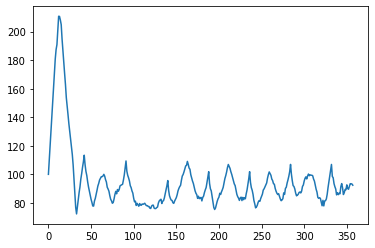

In [7]:
plt.plot(r.yaw)

In [8]:
# Why is the peak ground increase not at angle = 0?

Plot max attainable delta-v against obtained delta-v

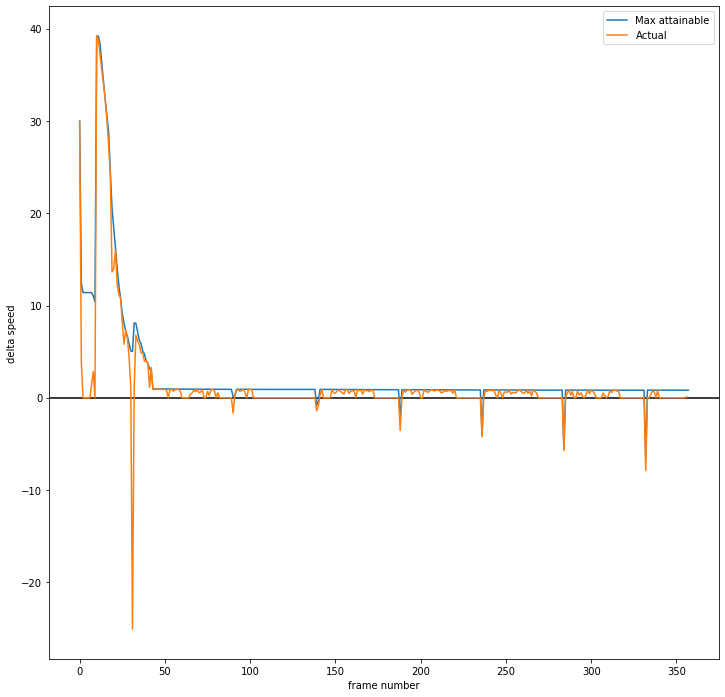

In [9]:
plt.figure(figsize=(12, 12))
plt.axhline(0, color='black')
plt.xlabel('frame number')
plt.ylabel('delta speed')
plt.plot(np.max(r.hypothetical_delta_speeds, axis=0), label='Max attainable')
plt.plot(np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1)), label='Actual')
plt.legend()

Velocity over time

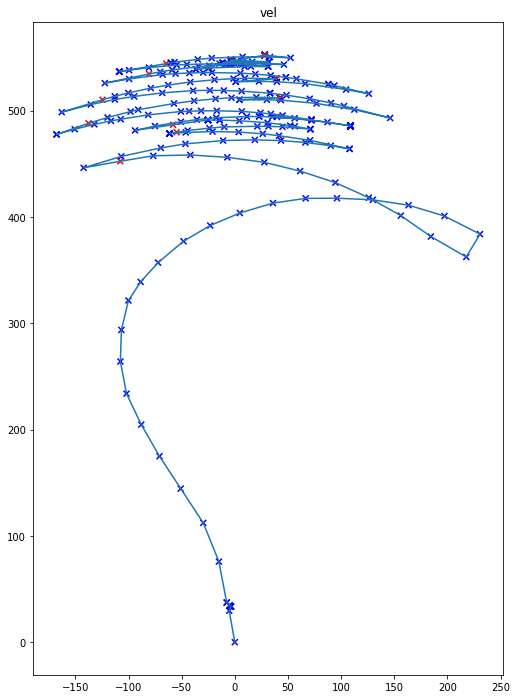

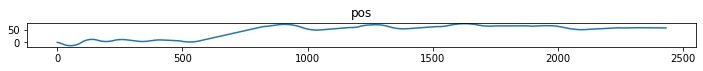

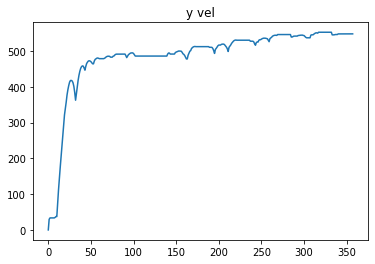

In [10]:
vel = r.player_state.vel
pos = np.cumsum(vel, axis=0) * 0.014

plt.figure(figsize=(12, 12))
plt.axes().set_aspect('equal')
plt.title('vel')
plt.plot(vel[:, 0], vel[:, 1])
c = np.where(np.concatenate([np.diff(vel[:, 2] > 1e-2), [False]]),
             'red', 'blue')
plt.scatter(vel[:, 0], vel[:, 1], c=c, marker='x')
plt.show()

plt.figure(figsize=(12, 12))
plt.axes().set_aspect('equal')
plt.title('pos')
plt.plot(pos[:, 1], pos[:, 0])
plt.show()

plt.title('y vel')
plt.plot(vel[:, 1])

Per-frame attainable delta speed given relative angle, with actual angle, delta speed plotted

In [ ]:
FRAME_NUM = 55

In [ ]:
FRAME_NUM += 1

plt.figure(figsize=(12, 12))
plt.title(FRAME_NUM)
# plt.ylim(-2, np.max(delta_speeds[:, FRAME_NUM]) + 2)
plt.axvline(-90)
plt.axvline(90)
plt.plot(np.arange(-180, 180), delta_speeds[:, FRAME_NUM])

plt.scatter((wish_angle - move_angle)[FRAME_NUM],
            np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1))[FRAME_NUM])

In [ ]:
#Blank space to avoid scrolling when the above image redraws











































